# Confidence intervals through Monte Carlo sampling

INCA can obtain confidence interval using Monte Carlo sampling for a set of estimated fluxes. In this notebook, we show how to use the this functionality with the INCA parser. This guide will focus on how to run Monte Carlo sampling and load the results. Please refer to other guides for a more detailed description of how to load the data and setup the INCA script. 

In [1]:
import pandas as pd
import pathlib
from BFAIR.mfa.INCA.INCAScript_writing import define_options, define_runner, create_inca_script_from_data
from BFAIR.mfa.INCA.run_inca import run_inca
from BFAIR.mfa.INCA.INCAResults import INCAResults
import ast
import pandas as pd

Again, we will use the simple toy model, that we also used in other guides. First, we load the data.

In [2]:
data_folder = pathlib.Path("./Literature data/simple model")
tracers_data = pd.read_csv(data_folder / "tracers.csv", 
   converters={'atom_mdv':ast.literal_eval, 'atom_ids':ast.literal_eval} # a trick to read lists from csv
)
reactions_data = pd.read_csv(data_folder / "reactions.csv")
flux_data = pd.read_csv(data_folder / "flux_measurements.csv")
ms_data = pd.read_csv(data_folder / "ms_measurements.csv", 
   converters={'labelled_atom_ids': ast.literal_eval} # a trick to read lists from csv
)

To run the Monte Carlo sampling simply set the `run_montecarlo` argument to True in the define_runner() function. The settings for the Monte Carlo algorithm is defined in the options block using the `define_options()` function. Please refer to the INCA documentation to see which options are available. The Monte Carlo algorithm require a estimate algorithm to be run first. Therefore, we also set the `run_estimate=True`. Finally the `run_simuation=True` to be able to open the estimate in the INCA GUI. 

NB. currently it is not possible to open the results of the Monte Carlo sampling in the INCA GUI.

The results of the Monte Carlo sampling will be saved to a separate `.mat` file. This file will named `<output_file>_mc.mat`, where `<output_file>` is the output file given to the `define_runner()` function.

In [3]:
output_file = pathlib.Path("simple_model_mc_tutorial.mat")
script = create_inca_script_from_data(reactions_data, tracers_data, flux_data, ms_data, experiment_ids=["exp1"])
script.add_to_block("options", define_options(fit_starts=5,sim_na=False))
script.add_to_block("runner", define_runner(output_file, run_estimate=True, run_simulation=True, run_montecarlo=True))

On larger models running monte carlo sampling can be computational heavy and thus take a while. Therefore, INCA produces a file called `dump.mat` which contains the temporary results. If the process is interrupted the results are store in dump files. By default the run_inca function runs INCA in a temporary directory, thus if the process is interrupted the dump file with be destroyed. Therefore, we recommend to specify an execution directory, when running monte carlo sampling to keep the results even is the process is interrupted.

In [4]:
import dotenv
inca_directory = pathlib.Path(dotenv.get_key(dotenv.find_dotenv(), "INCA_base_directory"))
run_inca(script, INCA_base_directory=inca_directory, execution_directory=pathlib.Path("."))

INCA script saved to inca_script.m.
Starting MATLAB engine...
 
ms_exp1 = 1x1 msdata object
 
fields: atoms  id  [idvs]  more  on  state  
 
F1
 
 
m = 1x1 model object
 
fields: [expts]  [mets]  notes  [options]  [rates]  [states]  
 
	5 reactions (6 fluxes)                                  
	6 states (3 balanced, 1 source, 2 sink and 0 unbalanced)
	6 metabolites                                           
	1 experiments                                           
 

                                         Directional 
 Iteration      Residual     Step-size    derivative        Lambda
     0        9.9944e+11
     1           5804.76             1     -1.41e+06      0.055422
     2           5007.27             1          91.7      0.018474
     3              5000             1        -0.061      0.006158
                                                    
 Optimization terminated: Constrained optimum found.
 Parameters converged to within tolerance.          

                      

The INCA run above produces two files.
- `simple_model_mc_tutorial.mat` - This regular output file which also can be opened in the INCA GUI. It contains the results of flux estimation.
- `simple_model_mc_tutorial_mc.mat` - The Monte Carlo results. This contain the Monte Carlo samples and the resulting confidence intervals of all the parameters.

We can now load the results of both the flux estimation and the Monte Carlo sampling by setting the argument `load_mc_data=True`. This expects the Monte Carlo results file to be named `<output_file>_mc.mat`, so don't renamed it.

In [5]:
res = INCAResults(output_file, load_mc_data=True)

We now have a `INCAResults` object which contain all the results from the INCA run. It contains the regular fitdata object.

In [13]:
res.fitdata.fitted_parameters.head()

,type,id,eqn,val,std,lb,ub,unit,free,alf,chi2s,cont,cor,cov,vals,base
0,Net flux,R1,A -> B,10.000000,0.000010,[],[],[],0,0.05,[],1,"[1.0, 8.947180823800999e-05, 2.001878044069642...","[9.999999786569624e-11, 6.084379181037214e-11,...",[],{'id': []}
1,Net flux,R2 net,B <-> D,6.084392,0.068003,[],[],[],1,0.05,[],1,"[8.947183374740735e-05, 1.0000000000000002, 0....","[6.08438091576069e-11, 0.004624450374797487, 0...",[],{'id': []}
2,Exch flux,R2 exch,B <-> D,6.622064,0.330789,[],[],[],1,0.05,[],1,"[2.0018802466302172e-05, 0.9284305366883899, 0...","[6.622009190992983e-11, 0.020884840724919265, ...",[],{'id': []}
3,Net flux,R3,B -> C + E,1.957804,0.034002,[],[],[],1,0.05,[],1,"[5.7579827150734644e-05, -0.9999999891879064, ...","[1.9578094354044673e-11, -0.002312225156976847...",[],{'id': []}
4,Net flux,R4,B + C -> D + E + E,1.957804,0.034002,[],[],[],0,0.05,[],1,"[5.7579827150734644e-05, -0.9999999891879064, ...","[1.9578094354044673e-11, -0.002312225156976847...",[],{'id': []}


But also a `INCAMonteCarloResults` object in the `.mc` attribute. This object contains the confidence intervals and the samples.

In [14]:
res.mc.ci

,R1,R2 net,R2 exch,R3,R4,R5,exp1 F1 exp1_F1_0_0_1 norm
lb,9.999982,5.955449,5.983408,1.894833,1.894833,7.977727,0.953104
ub,10.000019,6.210325,7.252106,2.022278,2.022278,8.105158,1.017404


In [15]:
res.mc.samples.head()

,R1,R2 net,R2 exch,R3,R4,R5,exp1 F1 exp1_F1_0_0_1 norm
0,10.000015,6.102361,6.919975,1.948827,1.948827,8.051188,0.983360
1,9.999991,6.145509,6.825952,1.927241,1.927241,8.072750,1.015415
2,9.999999,6.141134,6.703175,1.929432,1.929432,8.070566,1.010649
3,10.000009,6.046495,6.415860,1.976757,1.976757,8.023252,0.976130
4,9.999998,6.069195,6.477254,1.965401,1.965401,8.034597,0.992278


Each row in the `.samples` dataframe is a sample from the Monte Carlo sampling algorithm. It is easy to visualize the samples of one parameter (e.g. reaction) as a histogram using matplotlib.

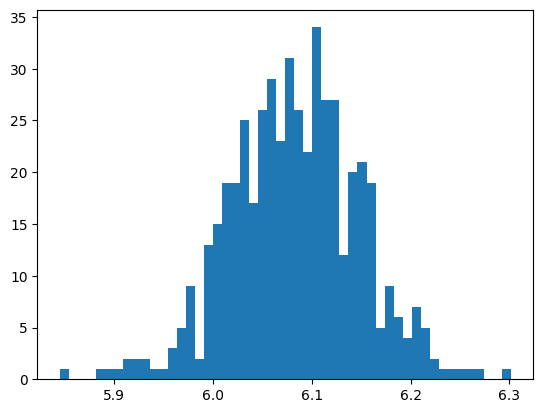

In [17]:
import matplotlib.pyplot as plt
plt.hist(res.mc.samples["R2 net"], bins=50)
plt.show()

Alternatively, one can inspect the correlations using the `pandas.plotting.scatter_matrix()`, note we recommend not plotting all parameters at the same time as this can make huge plots.

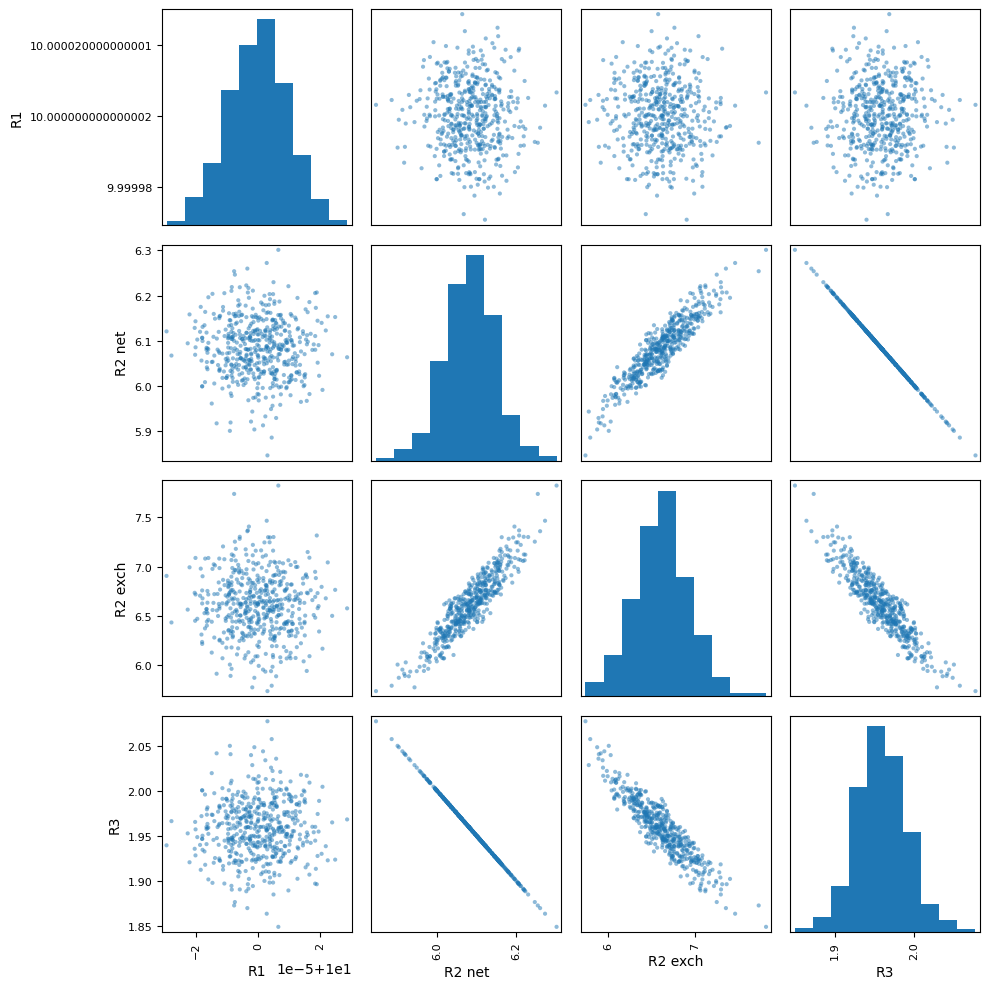

In [18]:
g = pd.plotting.scatter_matrix(res.mc.samples.filter(['R1', 'R2 net', 'R2 exch', 'R3']), figsize=(10,10))
plt.tight_layout()
plt.show()